# 경제 분석 및 예측과 데이터 지능 5

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch import arch_model
import matplotlib.pyplot as plt
from scipy.stats import f, t as t_dist

In [22]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. 환율 데이터 ARCH 모형
# ───────────────────────────────────────────────────────────────────────────────

# (1) 데이터 로드 및 문자열 → 숫자 변환
df_fx = pd.read_csv("../datasets/KOSPI_FX_daily.csv", parse_dates=["Date"])
df_fx = df_fx.sort_values("Date").reset_index(drop=True)
# FX 컬럼: 쉼표 제거 후 float 변환
df_fx["FX"] = df_fx["FX"].str.replace(",", "").astype(float)
df_fx = df_fx.dropna(subset=["FX"]).copy()
df_fx

,Date,KOSPI,FX
0,2015-01-02,"1,926.44",1103.5
1,2015-01-05,"1,915.75",1109.9
2,2015-01-06,"1,882.45",1098.8
3,2015-01-07,"1,883.83",1099.9
4,2015-01-08,"1,904.65",1096.9
...,...,...,...
2462,2024-12-23,"2,442.01",1452.0
2463,2024-12-24,"2,440.52",1456.4
2464,2024-12-26,"2,429.67",1464.8
2465,2024-12-27,"2,404.77",1467.5


In [23]:
# (2) 로그 수익률 r_t = log(FX_t) - log(FX_{t-1})
df_fx["log_FX"] = np.log(df_fx["FX"])
df_fx["r"] = df_fx["log_FX"].diff()
df_fx = df_fx.dropna(subset=["r"]).reset_index(drop=True)
df_fx

,Date,KOSPI,FX,log_FX,r
0,2015-01-05,"1,915.75",1109.9,7.012025,0.005783
1,2015-01-06,"1,882.45",1098.8,7.001974,-0.010051
2,2015-01-07,"1,883.83",1099.9,7.002975,0.001001
3,2015-01-08,"1,904.65",1096.9,7.000243,-0.002731
4,2015-01-09,"1,924.70",1090.0,6.993933,-0.006310
...,...,...,...,...,...
2452,2024-12-23,"2,442.01",1452.0,7.280697,0.000413
2453,2024-12-24,"2,440.52",1456.4,7.283723,0.003026
2454,2024-12-26,"2,429.67",1464.8,7.289474,0.005751
2455,2024-12-27,"2,404.77",1467.5,7.291316,0.001842


In [6]:
# (3) AR(1) 회귀: r_t = φ0 + φ1·r_{t-1} + u_t → 잔차 û_t 획득
df_fx["r_lag1"] = df_fx["r"].shift(1)
df_fx_ols = df_fx.dropna(subset=["r_lag1"]).copy()
X = sm.add_constant(df_fx_ols["r_lag1"])
y = df_fx_ols["r"]
model_ar1 = sm.OLS(y, X).fit()
df_fx_ols["u_hat"] = model_ar1.resid
df_fx_ols

,Date,KOSPI,FX,log_FX,r,r_lag1,u_hat
1,2015-01-06,"1,882.45",1098.8,7.001974,-0.010051,0.005783,-0.009823
2,2015-01-07,"1,883.83",1099.9,7.002975,0.001001,-0.010051,0.000270
3,2015-01-08,"1,904.65",1096.9,7.000243,-0.002731,0.001001,-0.002793
4,2015-01-09,"1,924.70",1090.0,6.993933,-0.006310,-0.002731,-0.006598
5,2015-01-12,"1,920.95",1081.4,6.986012,-0.007921,-0.006310,-0.008425
...,...,...,...,...,...,...,...
2452,2024-12-23,"2,442.01",1452.0,7.280697,0.000413,-0.000344,0.000270
2453,2024-12-24,"2,440.52",1456.4,7.283723,0.003026,0.000413,0.002929
2454,2024-12-26,"2,429.67",1464.8,7.289474,0.005751,0.003026,0.005812
2455,2024-12-27,"2,404.77",1467.5,7.291316,0.001842,0.005751,0.002067


In [7]:
# (4) 보조 회귀: û_t² = α0 + α1·û_{t-1}² + ... + αm·û_{t-m}² + η_t, m=5로 예시
m = 5
for lag in range(1, m + 1):
    df_fx_ols[f"u2_lag{lag}"] = df_fx_ols["u_hat"].shift(lag) ** 2
df_aux = df_fx_ols.dropna(subset=[f"u2_lag{lag}" for lag in range(1, m + 1)]).copy()
df_aux["u2"] = df_aux["u_hat"] ** 2
df_aux

,Date,KOSPI,FX,log_FX,r,r_lag1,u_hat,u2_lag1,u2_lag2,u2_lag3,u2_lag4,u2_lag5,u2
6,2015-01-13,"1,917.14",1083.5,6.987952,0.001940,-0.007921,0.001339,7.098278e-05,4.352967e-05,7.799911e-06,7.307190e-08,9.650064e-05,1.791981e-06
7,2015-01-14,"1,913.66",1082.2,6.986751,-0.001201,0.001940,-0.001205,1.791981e-06,7.098278e-05,4.352967e-05,7.799911e-06,7.307190e-08,1.452698e-06
8,2015-01-15,"1,914.14",1083.3,6.987767,0.001016,-0.001201,0.000821,1.452698e-06,1.791981e-06,7.098278e-05,4.352967e-05,7.799911e-06,6.743173e-07
9,2015-01-16,"1,888.13",1077.3,6.982213,-0.005554,0.001016,-0.005615,6.743173e-07,1.452698e-06,1.791981e-06,7.098278e-05,4.352967e-05,3.152467e-05
10,2015-01-19,"1,902.62",1078.0,6.982863,0.000650,-0.005554,0.000191,3.152467e-05,6.743173e-07,1.452698e-06,1.791981e-06,7.098278e-05,3.663064e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,2024-12-23,"2,442.01",1452.0,7.280697,0.000413,-0.000344,0.000270,4.873578e-08,1.230893e-04,5.399223e-06,7.162818e-06,1.739860e-06,7.308542e-08
2453,2024-12-24,"2,440.52",1456.4,7.283723,0.003026,0.000413,0.002929,7.308542e-08,4.873578e-08,1.230893e-04,5.399223e-06,7.162818e-06,8.576713e-06
2454,2024-12-26,"2,429.67",1464.8,7.289474,0.005751,0.003026,0.005812,8.576713e-06,7.308542e-08,4.873578e-08,1.230893e-04,5.399223e-06,3.377960e-05
2455,2024-12-27,"2,404.77",1467.5,7.291316,0.001842,0.005751,0.002067,3.377960e-05,8.576713e-06,7.308542e-08,4.873578e-08,1.230893e-04,4.274144e-06


In [9]:
# (4-1) Unrestricted model (보조 회귀 전체) → SSR_unres
X_aux = sm.add_constant(df_aux[[f"u2_lag{lag}" for lag in range(1, m + 1)]])
y_aux = df_aux["u2"]
model_aux = sm.OLS(y_aux, X_aux).fit()
SSR_unres = np.sum(model_aux.resid ** 2)
SSR_unres

1.0457977314293697e-05

In [11]:
# (4-2) Restricted model (α1=...=αm=0; u2_t = α0 + η_t) → SSR_res
X_res = sm.add_constant(np.ones(len(df_aux)))
model_res = sm.OLS(y_aux, X_res).fit()
SSR_res = np.sum(model_res.resid ** 2)
SSR_res

1.0878791347472617e-05

In [12]:
# (4-3) F-통계량 계산 및 p-value
T_eff = len(df_aux)
df_num = m
df_den = T_eff - (m + 1)
F_stat = ((SSR_res - SSR_unres) / df_num) / (SSR_unres / df_den)
p_value_F = 1 - f.cdf(F_stat, df_num, df_den)
print("=== ARCH 효과 기본 검정 ===")
print(f"F({df_num}, {df_den}) = {F_stat:.4f}, p-value = {p_value_F:.4e}")

=== ARCH 효과 기본 검정 ===
F(5, 2445) = 19.6767, p-value = 1.1102e-16


In [ ]:
# (5) ARCH(p) 모형 차수 선택: AIC/BIC 기준 (p = 1~10)
aic_list, bic_list = [], []
for p in range(1, 11):
    am = arch_model(df_fx_ols["r"].dropna(), vol="ARCH", p=p, o=0, dist="normal")
    res = am.fit(disp="off")
    aic_list.append((p, res.aic))
    bic_list.append((p, res.bic))
best_aic_p = min(aic_list, key=lambda x: x[1])[0]
best_bic_p = min(bic_list, key=lambda x: x[1])[0]
print("\n=== ARCH 모형 차수 선택 ===")
print(f"AIC 기준 최적 p = {best_aic_p}, BIC 기준 최적 p = {best_bic_p}")


=== ARCH 모형 차수 선택 ===
AIC 기준 최적 p = 9, BIC 기준 최적 p = 8


/Users/minkeychang/anaconda3/envs/forecasting_lecture/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.977e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/minkeychang/anaconda3/envs/forecasting_lecture/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.977e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.wa

In [14]:
# (6) ARCH(p) 모형 추정 (MLE) — AIC 기준 p 사용
arch_p = best_aic_p
am_final = arch_model(df_fx_ols["r"].dropna(), vol="ARCH", p=arch_p, o=0, dist="normal")
res_arch = am_final.fit(disp="off")
print("\n=== ARCH(p) 모형 추정 결과 ===")
print(res_arch.summary())


=== ARCH(p) 모형 추정 결과 ===
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      r   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                9406.60
Distribution:                  Normal   AIC:                          -18791.2
Method:            Maximum Likelihood   BIC:                          -18727.3
                                        No. Observations:                 2456
Date:                Fri, Jun 06 2025   Df Residuals:                     2455
Time:                        19:11:23   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3249e-04  1.017e

/Users/minkeychang/anaconda3/envs/forecasting_lecture/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.977e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


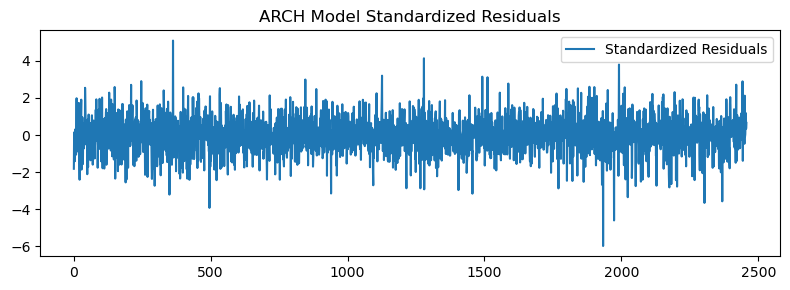

In [15]:
# (7) 모형 진단
std_resid = res_arch.std_resid
plt.figure(figsize=(8, 3))
plt.plot(std_resid, label="Standardized Residuals")
plt.title("ARCH Model Standardized Residuals")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# (7-1) 표준화 잔차 자기상관 검정 (Ljung-Box)
lb_test_df = acorr_ljungbox(std_resid, lags=[10], return_df=True)
stat_lb = lb_test_df["lb_stat"].iloc[0]
pvalue_lb = lb_test_df["lb_pvalue"].iloc[0]
print("\n=== 표준화 잔차 Ljung-Box 검정 (lags=10) ===")
print(f"Stat = {stat_lb:.4f}, p-value = {pvalue_lb:.4e}")


=== 표준화 잔차 Ljung-Box 검정 (lags=10) ===
Stat = 8.7608, p-value = 5.5495e-01


In [17]:
# (7-2) 표준화 잔차에 대한 ARCH 효과 검정 (LM)
arch_test_stat, arch_test_p, _, _ = het_arch(std_resid, nlags=arch_p)
print("\n=== 표준화 잔차 ARCH LM 검정 ===")
print(f"LM stat = {arch_test_stat:.4f}, p-value = {arch_test_p:.4e}")


=== 표준화 잔차 ARCH LM 검정 ===
LM stat = 10.4916, p-value = 3.1217e-01



=== GARCH(1,1) 모형 추정 결과 ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7985.32
Distribution:                  Normal   AIC:                          -15962.6
Method:            Maximum Likelihood   BIC:                          -15939.4
                                        No. Observations:                 2457
Date:                Fri, Jun 06 2025   Df Residuals:                     2456
Time:                        19:12:38   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.5808e-04  1.286e

/Users/minkeychang/anaconda3/envs/forecasting_lecture/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


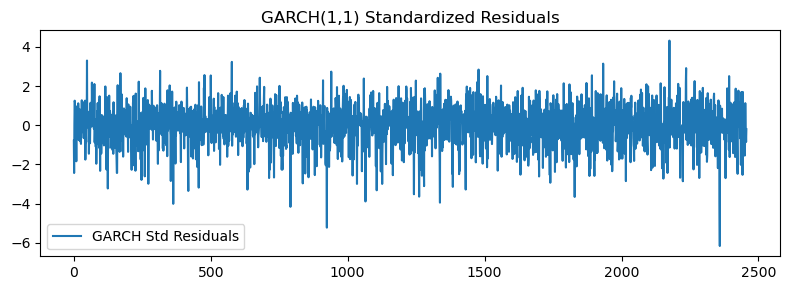

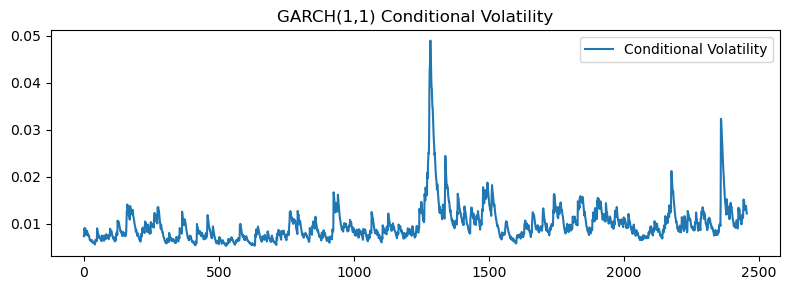


=== GARCH 표준화 잔차 Ljung-Box 검정 (lags=10) ===
Stat = 9.4561, p-value = 4.8943e-01

=== GARCH 표준화 잔차 ARCH LM 검정 ===
LM stat = 9.9840, p-value = 7.5690e-02


In [18]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. KOSPI 지수 수익률에 대한 GARCH(1,1) 모형 적용
# ───────────────────────────────────────────────────────────────────────────────

# (1) KOSPI 컬럼: 쉼표 제거 후 float 변환
df_kospi = pd.read_csv("../datasets/KOSPI_FX_daily.csv", parse_dates=["Date"])
df_kospi = df_kospi.sort_values("Date").reset_index(drop=True)
df_kospi["KOSPI"] = df_kospi["KOSPI"].str.replace(",", "").astype(float)
df_kospi = df_kospi.dropna(subset=["KOSPI"]).copy()

# (2) 일간 로그 수익률 계산
df_kospi["log_KOSPI"] = np.log(df_kospi["KOSPI"])
df_kospi["ret"] = df_kospi["log_KOSPI"].diff()
df_kospi = df_kospi.dropna(subset=["ret"]).reset_index(drop=True)

# (3) GARCH(1,1) 모형 추정 (MLE)
am_garch = arch_model(df_kospi["ret"], mean="Constant", vol="GARCH", p=1, q=1, dist="normal")
res_garch = am_garch.fit(disp="off")
print("\n=== GARCH(1,1) 모형 추정 결과 ===")
print(res_garch.summary())

# (4) 진단
std_resid_g = res_garch.std_resid
cond_vol = res_garch.conditional_volatility

plt.figure(figsize=(8, 3))
plt.plot(std_resid_g, label="GARCH Std Residuals")
plt.title("GARCH(1,1) Standardized Residuals")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(cond_vol, label="Conditional Volatility")
plt.title("GARCH(1,1) Conditional Volatility")
plt.legend()
plt.tight_layout()
plt.show()

lb_test_g_df = acorr_ljungbox(std_resid_g, lags=[10], return_df=True)
stat_lb_g = lb_test_g_df["lb_stat"].iloc[0]
pvalue_lb_g = lb_test_g_df["lb_pvalue"].iloc[0]
print("\n=== GARCH 표준화 잔차 Ljung-Box 검정 (lags=10) ===")
print(f"Stat = {stat_lb_g:.4f}, p-value = {pvalue_lb_g:.4e}")

arch_stat_g, arch_p_g, _, _ = het_arch(std_resid_g, nlags=5)
print("\n=== GARCH 표준화 잔차 ARCH LM 검정 ===")
print(f"LM stat = {arch_stat_g:.4f}, p-value = {arch_p_g:.4e}")

In [24]:
# ───────────────────────────────────────────────────────────────────────────────
# 3. 단일 시계열 Dickey–Fuller vs. Augmented Dickey–Fuller 검정 비교
# ───────────────────────────────────────────────────────────────────────────────

df_cpi_ir = pd.read_csv("../datasets/CPI_IR_monthly.csv", parse_dates=["Date"])
df_cpi = df_cpi_ir.sort_values("Date").set_index("Date").asfreq("MS").copy()
df_cpi["CPI"] = pd.to_numeric(df_cpi["CPI"], errors="coerce")
df_cpi = df_cpi.dropna(subset=["CPI"]).copy()

In [25]:
df_cpi["log_CPI"] = np.log(df_cpi["CPI"])
df_cpi["dlog_CPI"] = df_cpi["log_CPI"].diff()
series = df_cpi["dlog_CPI"].dropna()

In [26]:
# Case 1: Dickey–Fuller (no constant, no trend, lag=0) → regression="n"
dfuller_case1 = adfuller(series, maxlag=0, regression="n", autolag=None)
print("\n=== Dickey–Fuller 검정 (Case 1: no constant, no trend, lag=0) ===")
print(f"Test Statistic = {dfuller_case1[0]:.4f}, p-value = {dfuller_case1[1]:.4e}")


=== Dickey–Fuller 검정 (Case 1: no constant, no trend, lag=0) ===
Test Statistic = -10.6908, p-value = 3.2069e-19


In [27]:
# Case 2: Dickey–Fuller (constant only, no trend, lag=0) → regression="c"
dfuller_case2 = adfuller(series, maxlag=0, regression="c", autolag=None)
print("\n=== Dickey–Fuller 검정 (Case 2: constant only, lag=0) ===")
print(f"Test Statistic = {dfuller_case2[0]:.4f}, p-value = {dfuller_case2[1]:.4e}")


=== Dickey–Fuller 검정 (Case 2: constant only, lag=0) ===
Test Statistic = -13.0651, p-value = 2.0096e-24


In [28]:
# ADF 검정 (autolag="AIC")
adf_case1 = adfuller(series, regression="n", autolag="AIC")
adf_case2 = adfuller(series, regression="c", autolag="AIC")
print("\n=== ADF 검정 (Case 1: no constant, no trend, autolag=AIC) ===")
print(f"Test Statistic = {adf_case1[0]:.4f}, p-value = {adf_case1[1]:.4e}, usedlag = {adf_case1[2]}")
print("\n=== ADF 검정 (Case 2: constant only, autolag=AIC) ===")
print(f"Test Statistic = {adf_case2[0]:.4f}, p-value = {adf_case2[1]:.4e}, usedlag = {adf_case2[2]}")


=== ADF 검정 (Case 1: no constant, no trend, autolag=AIC) ===
Test Statistic = -1.6514, p-value = 9.3236e-02, usedlag = 11

=== ADF 검정 (Case 2: constant only, autolag=AIC) ===
Test Statistic = -3.0282, p-value = 3.2347e-02, usedlag = 11


In [29]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. 금리·인플레이션 상호관계 분석
# ───────────────────────────────────────────────────────────────────────────────

df_cpi_ir = pd.read_csv("../datasets/CPI_IR_monthly.csv", parse_dates=["Date"])
df_cpi_ir = df_cpi_ir.set_index("Date").asfreq("MS").copy()
df_cpi_ir["CPI"] = pd.to_numeric(df_cpi_ir["CPI"], errors="coerce")
df_cpi_ir["Interest"] = pd.to_numeric(df_cpi_ir["Interest"], errors="coerce")
df_cpi_ir = df_cpi_ir.loc["2005-01-01":"2024-12-31"].dropna(subset=["CPI", "Interest"]).copy()

df_cpi_ir["log_CPI"] = np.log(df_cpi_ir["CPI"])
df_cpi_ir["pi"] = df_cpi_ir["log_CPI"].diff()
df_cpi_ir["log_i"] = np.log(df_cpi_ir["Interest"])
df_coin = df_cpi_ir.dropna(subset=["pi", "log_i"]).copy()

In [30]:
# (2-1) 단위근 검정: log_i, pi 각각 ADF (constant only)
adf_li = adfuller(df_coin["log_i"], regression="c", autolag="AIC")
adf_pi = adfuller(df_coin["pi"], regression="c", autolag="AIC")
print("\n=== log_i ADF 검정 ===")
print(f"Test Statistic = {adf_li[0]:.4f}, p-value = {adf_li[1]:.4e}")
print("\n=== pi ADF 검정 ===")
print(f"Test Statistic = {adf_pi[0]:.4f}, p-value = {adf_pi[1]:.4e}")


=== log_i ADF 검정 ===
Test Statistic = -2.1804, p-value = 2.1343e-01

=== pi ADF 검정 ===
Test Statistic = -2.6719, p-value = 7.9026e-02


In [31]:
# (2-2) Engle–Granger 1단계: OLS 회귀 log_i = β0 + β1·pi + u_t
X2 = sm.add_constant(df_coin["pi"])
y2 = df_coin["log_i"]
model_coint_ols = sm.OLS(y2, X2).fit()
df_coin["u_hat_coint"] = model_coint_ols.resid

# (2-3) Engle–Granger 2단계: 잔차 u_hat_coint ADF 검정 (constant only)
adf_resid = adfuller(df_coin["u_hat_coint"], regression="c", autolag="AIC")
print("\n=== 잔차 기반 ADF 검정 ===")
print(f"Test Statistic = {adf_resid[0]:.4f}, p-value = {adf_resid[1]:.4e}")


=== 잔차 기반 ADF 검정 ===
Test Statistic = -2.6782, p-value = 7.7889e-02


In [32]:
# (2-4) β1 = 1 검정 (t-검정)
beta1 = model_coint_ols.params["pi"]
se_beta1 = model_coint_ols.bse["pi"]
t_stat_beta1 = (beta1 - 1) / se_beta1
df_t = model_coint_ols.df_resid
p_value_beta1 = 2 * (1 - t_dist.cdf(abs(t_stat_beta1), df_t))
print("\n=== 공적분 계수 β1 = 1 검정 ===")
print(f"β1_hat = {beta1:.4f}, t-stat = {t_stat_beta1:.4f}, p-value = {p_value_beta1:.4e}")


=== 공적분 계수 β1 = 1 검정 ===
β1_hat = 13.6269, t-stat = 1.1108, p-value = 2.6776e-01


In [33]:
# (3) Johansen 공적분 검정
data_joh = df_coin[["log_i", "pi"]].dropna()
model_var = VAR(data_joh)
lag_order_results = model_var.select_order(12)
p_opt = lag_order_results.aic
print(f"\n=== VAR 최적 시차 (AIC) p = {p_opt} ===")


=== VAR 최적 시차 (AIC) p = 7 ===


In [34]:
joh_res = coint_johansen(data_joh, det_order=0, k_ar_diff=p_opt)
print("\n=== Johansen Trace 통계량 ===")
for i, stat in enumerate(joh_res.lr1):
    crit90, crit95, crit99 = joh_res.cvt[i]
    print(f"r = {i}: Trace stat = {stat:.4f}, crit(95%) = {crit95:.4f}")
print("\n=== Johansen Max-Eigen 통계량 ===")
for i, stat in enumerate(joh_res.lr2):
    crit90, crit95, crit99 = joh_res.cvm[i]
    print(f"r = {i}: Max-Eigen stat = {stat:.4f}, crit(95%) = {crit95:.4f}")

print("\n=== 공적분 벡터 (첫 번째 고유벡터) ===")
print(joh_res.evec[:, 0])


=== Johansen Trace 통계량 ===
r = 0: Trace stat = 26.6863, crit(95%) = 15.4943
r = 1: Trace stat = 6.0587, crit(95%) = 3.8415

=== Johansen Max-Eigen 통계량 ===
r = 0: Max-Eigen stat = 20.6276, crit(95%) = 14.2639
r = 1: Max-Eigen stat = 6.0587, crit(95%) = 3.8415

=== 공적분 벡터 (첫 번째 고유벡터) ===
[ 4.65919447e-01 -9.38426045e+02]
